In [11]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt


In [12]:
# Three arguments:
#   weights: (theta) parameters of the convnet
#   U(x; theta): energy, indirectly depends on parameters theta
#   x: sample

# Two gradients:
#   langevin steps update
#   gradient to update theta

# Positive vs negative samples:
#   positive: increases the probability of training data by reducing corresponding free energy
#   negative: decreases the probability of samples generated by the model

# as training progresses, negative samples should look like samples from the training set
# as the RBM becomes closer to true underlying distribution

In [59]:
class EnergyModel(nn.Module):
    def __init__(self, size, type = 'relu'):
        super(EnergyModel, self).__init__()
        self.size = size
        self.lr = 0.0005
        self.type = type

        # initialize energy model parameters theta

        self.run_relu = nn.Sequential(
            nn.Linear(self.size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, self.size),
            nn.ReLU()
        )

        self.run_tanh = nn.Sequential(
            nn.Linear(self.size, 1000),
            nn.Tanh(),
            nn.Linear(1000, 500),
            nn.Tanh(),
            nn.Linear(500, 250),
            nn.Tanh(),
            nn.Linear(250, self.size),
            nn.Tanh()
        )

        self.run_softplus = nn.Sequential(
            nn.Linear(self.size, 1000),
            nn.Softplus(),
            nn.Linear(1000, 500),
            nn.Softplus(),
            nn.Linear(500, 250),
            nn.Softplus(),
            nn.Linear(250, self.size),
            nn.Softplus()
        )

        self.run_sigmoid = nn.Sequential(
            nn.Linear(self.size, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 500),
            nn.Sigmoid(),
            nn.Linear(500, 250),
            nn.Sigmoid(),
            nn.Linear(250, self.size),
            nn.Sigmoid()
        )

        self.run_leakyrelu = nn.Sequential(
            nn.Linear(self.size, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 500),
            nn.LeakyReLU(0.2),
            nn.Linear(500, 250),
            nn.LeakyReLU(),
            nn.Linear(250, self.size),
            nn.LeakyReLU(0.2)
        )

        self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)


    # careful to add activation or else it becomes regular linear multiplication
    def forward(self, x):
        if self.type == 'tanh':
            x = self.run_tanh(x)
        elif self.type == 'softplus':
            x = self.run_softplus(x)
        elif self.type == 'leaky_relu':
            x = self.run_leakyrelu(x)
        elif self.type == 'sigmoid':
            x = self.run_sigmoid(x)
        else:
            x = self.run_relu(x)

        return x


    # energy function
    def U(self, x):
        return -1.0 * self.forward(x).sum()


    def go(self, data1, data2, epoch, pos_data, neg_data):
        energy_data = []
        self.train()

        # initialize variables from positive sample and negative sample of normal distribution
        # x_pos comes with sample data (X_train)
        # x_neg needs to be sampled from the starting values (X_demo)
        x_pos = torch.autograd.Variable((torch.tensor(data1, dtype = torch.float32)),
                requires_grad = True)
        x_neg = torch.autograd.Variable((torch.tensor(data2, dtype = torch.float32)),
                requires_grad = True)

        # update samples via stochastic gradient Langevin dynamics
        # use langevin to sample -- use x_neg as starting point and update it with gradient after every step
        # gradient of the energy function
        langevin_step_size = 0.001
        langevin_steps = 35
        for j in range(langevin_steps):
            x_neg_eng = self.U(x_neg)
            energy_data.append(x_neg_eng)
            x_neg_grad = torch.autograd.grad(x_neg_eng, x_neg)[0] # given theta and data
            noise = torch.sqrt(torch.tensor(0.5 * langevin_step_size)) * torch.randn_like(x_neg)
            x_neg.data = x_neg.data + 1.0 * (langevin_step_size) * (-x_neg_grad.data) + (noise)

        # goal: minimize energy by minimizing U(x_pos) and maximizing U(x_neg) [max x_pos and min x_neg]
        #       x_pos is the sample data
        #       x_neg is the data from repeated langevin steps
        # apply energy to each dataset to discover an energy function that
        # assigns low values to high probability events and vice versa
        self.optim.zero_grad()
        loss = self.U(x_pos) - self.U(x_neg)
        loss.backward()
        self.optim.step() # updating parameters
        self.eval()

        pos_data.append(self.U(x_pos).detach())
        neg_data.append(self.U(x_neg).detach())
        
        print("Loss: ", loss.data)
        #i epoch >= 50
        #   visualize(energy_data, epoch)

In [44]:
def visualize(data, epoch):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(data, dtype=torch.float)
    plt.title('Results on Epoch ' + str(epoch + 1))
    plt.xlabel('Steps')
    plt.ylabel('Energy')

    plt.plot(durations_t.numpy())
    plt.show()


def visualize_data(data):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(data, dtype=torch.float)
    plt.title('Results over Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Energy')

    plt.plot(durations_t.numpy())
    plt.show()

In [60]:
size = 500
epoch = 200

mean1 = 0
mean2 = 0
var1 = 10
var2 = 100

mean_arr1 = np.array((0, 0, 0))
mean_arr2 = np.array((0, 0, 0))
cov = np.array(([1, 0, 0], [0, 1, 0], [0, 0, 1]))
cov2 = np.array(([50, 0, 0], [0, 50, 0], [0, 0, 50]))
    

Loss:  tensor(7.3348)
Loss:  tensor(6.9709)
Loss:  tensor(10.0059)
Loss:  tensor(9.3708)
Loss:  tensor(7.1203)
Loss:  tensor(15.4779)
Loss:  tensor(31.5974)
Loss:  tensor(50.8116)
Loss:  tensor(-21.9494)
Loss:  tensor(-25.8481)
Loss:  tensor(28.8259)
Loss:  tensor(-5.2310)
Loss:  tensor(41.4530)
Loss:  tensor(8.8559)
Loss:  tensor(47.6441)
Loss:  tensor(-19.5103)
Loss:  tensor(55.4740)
Loss:  tensor(-67.2475)
Loss:  tensor(103.1991)
Loss:  tensor(76.8141)
Loss:  tensor(60.8653)
Loss:  tensor(81.8531)
Loss:  tensor(-31.6270)
Loss:  tensor(11.5681)
Loss:  tensor(47.0269)
Loss:  tensor(0.2645)
Loss:  tensor(-26.1480)
Loss:  tensor(32.3634)
Loss:  tensor(38.9204)
Loss:  tensor(-15.4335)
Loss:  tensor(3.7361)
Loss:  tensor(26.0331)
Loss:  tensor(-1.3877)
Loss:  tensor(15.5560)
Loss:  tensor(-52.4407)
Loss:  tensor(-35.6854)
Loss:  tensor(-41.3492)
Loss:  tensor(-74.2993)
Loss:  tensor(4.8199)
Loss:  tensor(-6.1022)
Loss:  tensor(-27.2706)
Loss:  tensor(68.8650)
Loss:  tensor(19.1956)
Loss: 

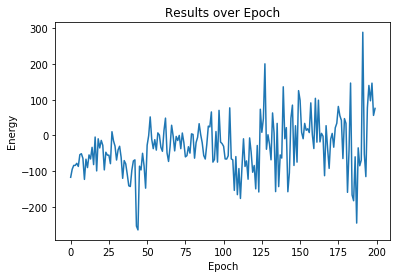

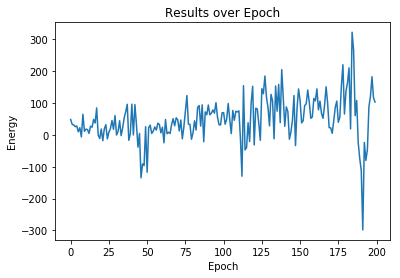

In [61]:
model = EnergyModel(size, 'tanh')
pos_data = []
neg_data = []

for i in range(epoch):
    # sample = np.random.normal(mean1, var1, size)
    # sample2 = np.random.normal(mean2, var2, size)

    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-5.1229)
Loss:  tensor(-47.7703)
Loss:  tensor(-89.4991)
Loss:  tensor(-272.7234)
Loss:  tensor(-408.7953)
Loss:  tensor(-599.8794)
Loss:  tensor(-1115.6669)
Loss:  tensor(-1824.1354)
Loss:  tensor(-2195.7161)
Loss:  tensor(-3515.1023)
Loss:  tensor(-4196.9238)
Loss:  tensor(-5578.8911)
Loss:  tensor(-7165.9810)
Loss:  tensor(-9900.9336)
Loss:  tensor(-12697.2627)
Loss:  tensor(-14549.5039)
Loss:  tensor(-14975.0645)
Loss:  tensor(-23633.3594)
Loss:  tensor(-22149.9863)
Loss:  tensor(-27348.9766)
Loss:  tensor(-29194.4727)
Loss:  tensor(-36446.2539)
Loss:  tensor(-37890.7969)
Loss:  tensor(-46937.1055)
Loss:  tensor(-41642.7656)
Loss:  tensor(-46592.3828)
Loss:  tensor(-33905.2188)
Loss:  tensor(-43645.5469)
Loss:  tensor(-50751.6719)
Loss:  tensor(-53599.6875)
Loss:  tensor(-62581.7656)
Loss:  tensor(-27190.6094)
Loss:  tensor(-55744.2344)
Loss:  tensor(-58777.9062)
Loss:  tensor(-55819.6875)
Loss:  tensor(-91678.3438)
Loss:  tensor(-100436.0625)
Loss:  tensor(-124876.75

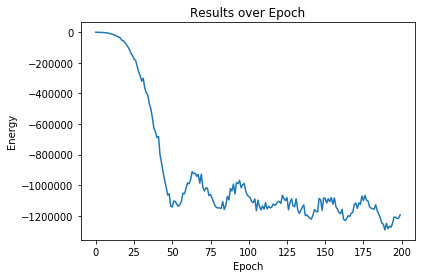

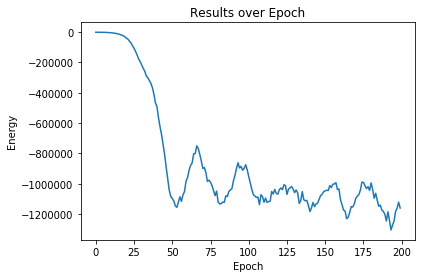

In [62]:
model = EnergyModel(size, 'softplus')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-107.1718)
Loss:  tensor(-168.6399)
Loss:  tensor(-254.2778)
Loss:  tensor(-420.7331)
Loss:  tensor(-668.5062)
Loss:  tensor(-950.9099)
Loss:  tensor(-1041.7595)
Loss:  tensor(-1630.5747)
Loss:  tensor(-2787.6165)
Loss:  tensor(-3211.1450)
Loss:  tensor(-4211.2500)
Loss:  tensor(-5799.7871)
Loss:  tensor(-8246.4580)
Loss:  tensor(-10128.5479)
Loss:  tensor(-12809.1768)
Loss:  tensor(-15316.9941)
Loss:  tensor(-19524.8711)
Loss:  tensor(-20065.6133)
Loss:  tensor(-27641.6055)
Loss:  tensor(-27367.5176)
Loss:  tensor(-25193.1523)
Loss:  tensor(-20874.7383)
Loss:  tensor(-16532.1719)
Loss:  tensor(-17910.8359)
Loss:  tensor(-15471.5312)
Loss:  tensor(-12591.0781)
Loss:  tensor(-21551.6953)
Loss:  tensor(-16876.0938)
Loss:  tensor(-19793.1016)
Loss:  tensor(-12424.2188)
Loss:  tensor(-54196.7500)
Loss:  tensor(-33211.9219)
Loss:  tensor(-49026.8438)
Loss:  tensor(-15294.6094)
Loss:  tensor(-46305.3125)
Loss:  tensor(-39842.3281)
Loss:  tensor(-41765.9375)
Loss:  tensor(-35431

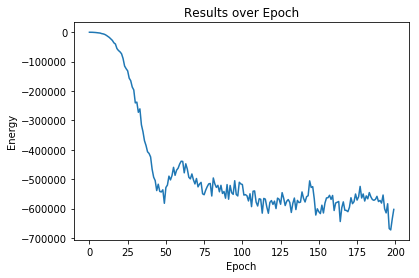

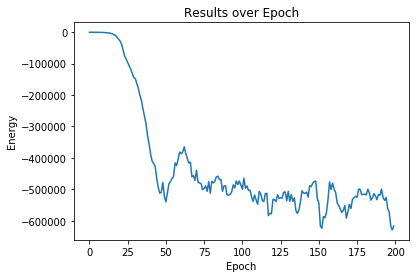

In [63]:
model = EnergyModel(size, 'leaky_relu')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-0.0164)
Loss:  tensor(-0.0341)
Loss:  tensor(-0.0982)
Loss:  tensor(-0.1485)
Loss:  tensor(0.0192)
Loss:  tensor(-0.1821)
Loss:  tensor(-0.2059)
Loss:  tensor(0.0164)
Loss:  tensor(0.3890)
Loss:  tensor(-1.0886)
Loss:  tensor(0.7524)
Loss:  tensor(-0.0706)
Loss:  tensor(-0.0471)
Loss:  tensor(0.9056)
Loss:  tensor(0.2714)
Loss:  tensor(-1.2260)
Loss:  tensor(0.0087)
Loss:  tensor(-0.5362)
Loss:  tensor(-0.1251)
Loss:  tensor(1.1567)
Loss:  tensor(-1.1340)
Loss:  tensor(-0.8469)
Loss:  tensor(0.2112)
Loss:  tensor(-0.3538)
Loss:  tensor(-1.1586)
Loss:  tensor(0.8846)
Loss:  tensor(0.1950)
Loss:  tensor(-2.6207)
Loss:  tensor(-0.4807)
Loss:  tensor(-0.8124)
Loss:  tensor(-3.7992)
Loss:  tensor(-2.5294)
Loss:  tensor(2.2143)
Loss:  tensor(-0.0533)
Loss:  tensor(-9.1793)
Loss:  tensor(-2.9999)
Loss:  tensor(-4.2692)
Loss:  tensor(1.6239)
Loss:  tensor(-11.4045)
Loss:  tensor(-7.0922)
Loss:  tensor(9.3002)
Loss:  tensor(0.1993)
Loss:  tensor(-4.4952)
Loss:  tensor(-1.0741)
Lo

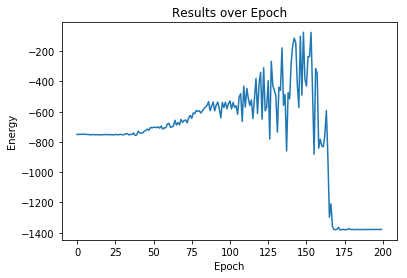

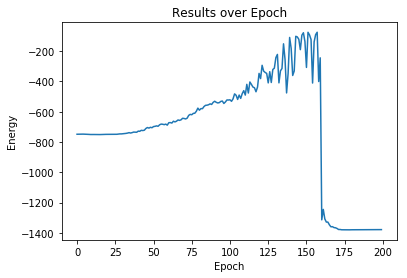

In [64]:
model = EnergyModel(size, 'sigmoid')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-171.1108)
Loss:  tensor(-236.0560)
Loss:  tensor(-403.4769)
Loss:  tensor(-724.0453)
Loss:  tensor(-1014.1102)
Loss:  tensor(-1372.0891)
Loss:  tensor(-2149.7839)
Loss:  tensor(-3448.8374)
Loss:  tensor(-4208.1274)
Loss:  tensor(-6004.2007)
Loss:  tensor(-8122.0742)
Loss:  tensor(-9875.3105)
Loss:  tensor(-11872.7891)
Loss:  tensor(-16302.1445)
Loss:  tensor(-20191.9629)
Loss:  tensor(-22403.5977)
Loss:  tensor(-28087.0898)
Loss:  tensor(-35536.1172)
Loss:  tensor(-36510.3867)
Loss:  tensor(-37495.9219)
Loss:  tensor(-49632.9219)
Loss:  tensor(-53729.8203)
Loss:  tensor(-59507.1797)
Loss:  tensor(-54121.1016)
Loss:  tensor(-74264.6094)
Loss:  tensor(-67889.4609)
Loss:  tensor(-53744.2031)
Loss:  tensor(-42933.8594)
Loss:  tensor(-42978.4219)
Loss:  tensor(-48816.8594)
Loss:  tensor(-35692.1406)
Loss:  tensor(-77383.5000)
Loss:  tensor(-70308.5938)
Loss:  tensor(-88621.7188)
Loss:  tensor(-108168.6875)
Loss:  tensor(-100222.5312)
Loss:  tensor(-91832.0938)
Loss:  tensor(-

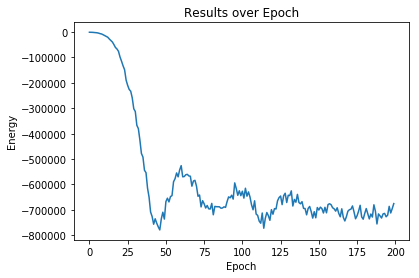

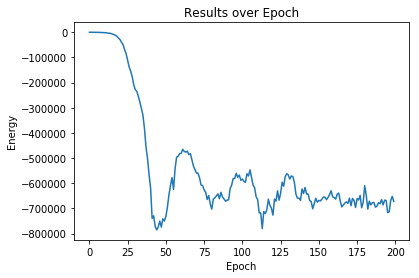

In [65]:
model = EnergyModel(size) # relu 
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)